# 0.0. Imports

## 0.1. Julia & Python Imports 

In [2]:
using CSV;
using PyCall;
using PyPlot;
using Printf;
using StatsBase;
using DataFrames, FreqTables
using HypothesisTests

np  = pyimport("numpy");
sns = pyimport("seaborn");
ss  = pyimport("scipy.stats");
wrg = pyimport("warnings");
pd  = pyimport("pandas");
gs  = pyimport("matplotlib.gridspec");

wrg.filterwarnings("ignore")

In [2]:
ps = pyimport("pyspark.pandas");
pd = pyimport("databricks.koalas");
tree = pyimport("sklearn.tree");
layers = pyimport("keras.layers");
models = pyimport("keras.models");
prepro = pyimport("sklearn.preprocessing");
utils  = pyimport("sklearn.utils");
metrics = pyimport("sklearn.metrics");
model_selection = pyimport("sklearn.model_selection");

## 0.2. Aux Functions

### 0.2.1. Functions

In [3]:
wrg.filterwarnings("ignore")

pearson_r(ti, df) = √( (ti^2) / (ti^2 + df ) );
glass_delt( x_bari, x_barj, stdi ) = (x_bari - x_barj) / stdi;
cohen_d(x_bari, x_barj, stdi, stdj) = ( x_bari - x_barj ) / √( ( stdi^2 + stdj^2 ) / 2 );
hedge_g( d, ni, nj ) = ( d * ( 1 - ( 3 / (4*(ni + nj - 9)))));

function cramer_v( x, y )
    cm = freqtable(x, y)
    n  = sum(cm)
    r, k = size(cm)
    
    chi2 = ChisqTest( cm ).stat
    chi2corr = max( 0, chi2 - ((( k-1 ) * ( r-1 )) / ( n-1 ) ))
    
    kcorr = k - ((( k-1 )^2) / ( n-1 ))
    rcorr = r - ((( r-1 )^2) / ( n-1 ))

    return sqrt( ( chi2corr / n ) / ( min( kcorr - 1, rcorr - 1 ) ) )
end;

function permutation(x, n_a, n_b)
    n = n_a + n_b
    rand_b = sample(1:n, n_b)
    rand_a = setdiff(1:n, rand_b)
    return np.mean(x[rand_b]) - np.mean(x[rand_a])
end;

function pages()
    info = []
    for i in ["Page A", "Page B"]
        mean = np.mean( df[df.Page .== i, 2] )
        std = np.std( df[df.Page .== i, 2] )
        n = length(df[df.Page .== i, 2])
        [append!(info, k) for k in [mean, std, n]];
    end
    return Dict("mean_a" => info[1], "std_a" => info[2], "n_a" => info[3],
                "mean_b" => info[4], "std_b" => info[5], "n_b" => info[6])
end;

function generate_data( x, y, z )
    res = []
    for k in [x, y, z]
        mean = np.mean( k )
        std = np.std( k )
        append!(res, [mean, std])
    end
    return Dict("mean_x1" => res[1], "std_x1" => res[2],
                "mean_x2" => res[3], "std_x2" => res[4],
                "mean_x3" => res[5], "std_x3" => res[6])
end

function permutation_chi2_julia()
    data = append!(vec(zeros(1, 2266)), vec(ones(1, 34)))
    data = round.(Int, data)
    values = [[ 14,   8,  12], [986, 992, 988]]
    expected = [34/3, 1000-(34/3)];
    function chi2( observed, expected )
        pearson_res = []
        for i in zip( observed, expected )
            append!(pearson_res, [(observe .- i[2])^2 / i[2] for observe in i[1]])
        end
        return sum(pearson_res)
    end
    chi2obsv = chi2(values, expected)
    function permutation_box( data )
        sample_click = [sum(py"samp"(sort(data))), sum(py"samp"(sort(data))), sum(py"samp"(sort(data)))]
        sample_noclick = [(1000 - i) for i in sample_click]
        return chi2([sample_click, sample_noclick], expected)
    end
    perm_chi2 = [permutation_box( data ) for _ in 1:2000]
    resample_p = sum(perm_chi2 .> chi2obsv) / length(perm_chi2)
    return [chi2obsv, resample_p]
end

py"""
import random
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as api
def test(diff, diff_mean):
    return np.mean(diff > diff_mean)
def samp(x):
    return random.sample( sorted(x), 1000)
def anova(df, ty, te, frm):
    return sm.stats.anova_lm(api.ols(frm, data=df).fit(), typ=ty, test=te)
"""

### 0.2.1. Plots

In [33]:
function plot_linear(a, b, d, r1, r2)
    fig, ax = plt.subplots( figsize=(6, 5) );

    x = np.arange( r1, r2, 1 )
    y = a * x .+ b + np.random.normal( 0, d, length(x) );
    r = (length(x)sum(x .* y) - (sum(x)sum(y))) / (sqrt((length(x)sum(x.^2) - (sum(x))^2) * (length(y)sum(y.^2) - (sum(y))^2)))
    
    ax = sns.regplot(x, y, color="r")
    if r >= 0
        ax.set_title(("Correlação Positiva: " * string(round(r, digits=4))))
    else
        ax.set_title(("Correlação Negativa: " * string(round(r, digits=4))))
    end
end;

function spearman_plot( size, power )
    log_a = [log1p(abs(j-10)) for j in 1:size]
    log_b = [log1p(j)^power for j in 1:size]
    cor, _ = ss.spearmanr( log_a, log_b );

    fig, ax = plt.subplots( figsize=(5, 5) )
    ax.plot( log_a, color="b", linestyle="--", label="Log - 6" )
    ax.plot( log_b, color="r", linestyle="--", label="Negative Log" )
    ax.set_title( "Correlação: " * string(round(cor, digits=4)) )
    plt.legend(); 
end;

function plot_density( x, y )
    fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(16, 7) )
    ax1.hexbin( np.random.randn(x), np.random.randn(y), gridsize=30, cmap="gist_heat" );
    ax2 = sns.kdeplot(np.random.randn(x), np.random.randn(y) );
end;

function plot_bootstrap( x, g_type, c )
    plt.hist( x, color=c, linewidth=2, histtype=g_type, bins=20 );
    plt.vlines( np.mean( x ), ymin=n_size-100, ymax=1., color="k", linestyle="--", label="Mean" );
    plt.legend();
end;

function plot_three_bn( prob, colors, label )
    for i in zip( [0.1, 0.5, 0.9], ["r", "g", "b"], ["Prob: 10%", "Prob: 50%", "Prob: 90%"] )
        res = [ss.binom.pmf(r, 10, i[1]) for r in 0:10]
        plt.bar(Array(1:11), res, color=i[2], label=i[3]);
        plt.legend()
    end
end;

function plot_normal_plus( x, x2, x3, x4, x5 )
    fig, ax = plt.subplots( figsize=(7, 4) )
    ax.plot(x, ss.norm.pdf(x), color="b", linewidth=2, label="Normal");
    for j in zip( [x2, x3, x4, x5], ["r", "b", "m", "c"])
        ax.plot(j[1], ss.norm.pdf(x2), color=j[2], linewidth=2 );
    end
    ax.hlines( .003, -4, 4, color="k")
    ax.vlines( 0, 0, 0.4, color="k", linestyle="--", label="Média")
    ax.set_title("Distribuição Normal")
    fig.legend();
end;

function plot_poisson( x, c )
    fig, ax = plt.subplots( figsize=(7, 4) )
    ax = sns.distplot(x, color=c, hist=false, label="Poisson");
    ax.vlines( np.mean(x), 0, 0.27, color="k", linestyle="--", label="Média" )
    ax.vlines( np.median(x), 0, 0.27, color="c", linestyle="--", label="Mediana" )
    ax.vlines( 0, -0.05, 0.28, color="#12004f", linewidth=2, linestyle="-")
    ax.hlines( -0.001, -1.7, 8.5, color="#12004f", linewidth=2, linestyle="-")
    ax.set_xlabel("Contagem");
    ax.set_ylabel("Densidade");
    ax.set_title("Distribuição Poisson")
    ax.legend();
end;

function plot_normal( x, sim=true )
    fig, ax = plt.subplots( figsize=(7, 4) )
    ax.plot(x, ss.norm.pdf(x), color="b", linewidth=2, label="Normal");
    ax.hlines( .003, -4, 4, color="k")
    ax.vlines( 0, 0, 0.4, color="k", linestyle="--", label="Média")
    ax.set_title("Distribuição Normal")
    fig.legend();
    if sim == true 
        [ax.vlines(  i, 0, 0.24, color="r") for i in -1:1 if i != 0]
        [ax.vlines(  i, 0, 0.055, color="r") for i in -2:2 if i != 0]
        [ax.vlines( -i, 0, (0.50/(i*2.0)-.01), color="r", linestyle="--" ) for i in 1:.1:1.3];
        [ax.vlines( -i, 0, (0.50/(i*2.3)-.01), color="r", linestyle="--" ) for i in 1.3:.1:1.6];
        [ax.vlines( -i, 0, (0.50/(i*3)-.01), color="r", linestyle="--" )   for i in 1.6:.1:1.9];
        [ax.vlines(  i, 0, (0.50/(i*2.0)-.01), color="r", linestyle="--" ) for i in 1:.1:1.3];
        [ax.vlines(  i, 0, (0.50/(i*2.3)-.01), color="r", linestyle="--" ) for i in 1.3:.1:1.6];
        [ax.vlines(  i, 0, (0.50/(i*3)-.01), color="r", linestyle="--" )   for i in 1.6:.1:1.9];
    else
    end
end;

function plot_qq(x, y, z, g_type)
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots( 2, 3, figsize=(16, 7) )
    ss.probplot( x, dist="norm", plot=ax1 );
    ss.probplot( y, dist="norm", plot=ax5 );
    ss.probplot( z, dist="norm", plot=ax3 );
    for i in zip( [ax2, ax6, ax4], [x, y, z], ["Normal", "Log", "Skewed"], ["r", "g", "b"] )
        i[1].hist( i[2], histtype=g_type, linewidth=2, color=i[4], label=i[3] );
        i[1].legend()
        i[1].set_ylabel("Density")
        i[1].set_xlabel("Bins")
        plt.show()
    end;
end;

function plot_exp( x, c )
    fig, ax = plt.subplots( figsize=(7, 4) )
    ax = sns.distplot(x, color=c, hist=false, label="Exponencial");
    ax.set_xlabel("Contagem");
    ax.vlines( np.mean(x), 0, 0.4, color="k", linestyle="--", label="Média" )
    ax.vlines( np.median(x), 0, 0.55, color="c", linestyle="--", label="Mediana" )
    ax.vlines( 0, 0, 0.7, color="#12004f", linestyle="-")
    ax.vlines( 0, -0.05, 0.28, color="#12004f", linewidth=2, linestyle="-")
    ax.hlines( -0.001, -1.7, 8.5, color="#12004f", linewidth=2, linestyle="-")
    ax.set_title("Distribuição Exponencial")
    ax.legend();
end;

function plot_wei(x)
    fig, ax = plt.subplots( figsize=(7, 4) )
    ax = sns.distplot( x, color=c, label="Weibull");
    ax.hlines( -.1/(1000*100), 150*150, -200, color="#12004f", linewidth=2, linestyle="-")
    ax.vlines( -.1/(1000*100), -.1/(500*10), .1/(500), color="#12004f", linewidth=2, linestyle="-")
    ax.set_title("Distribuição Weibull")
    ax.legend();
end;

function plot_permutation(x, d, c1, c2, ex, with_ex=false)
    fig, ax = plt.subplots( figsize=(6, 5))
    ax.hist(x, histtype="step", color="r", linewidth=2)
    ax.axvline( x=d, c=c1, lw=1, ls="--", label="Diferença" );
    if with_ex == true
        ax.vlines( ex, 0, 100, color=c2 );
        plt.legend();
    else
        plt.legend();
    end
end;

function plot_page_diff()
    fig, ax = plt.subplots( figsize=(7, 5) )
    ax.hist( df[df.Page .== "Page A", 2], histtype="step", linewidth=2, color="r", label="Page A")
    ax.hist( df[df.Page .== "Page B", 2], histtype="step", linewidth=2, color="b", label="Page B")
    ax.hlines( y=2.0, xmin=-0, xmax=4., linestyle="--", color="k" )
    ax.set_xlabel("Time")
    ax.set_ylabel("Count")
    ax.legend();
end;

# Capítulo 1

## 1.1. Correlação

### 1.1.1. R de Pearson

O coeficiente de correlação de pearson é muitas vezes o primeiro coeficiente estudado ou abordado em livros.<br>
São ditos os dados que são positivamente correlacionados quando os valores de **x** acompanham os valores de **y** e negativamente correlacionados se os valores altos de **x** acompanharem os valores baixos de **y**.<br>**Causalidade** a variável **x** é a causa da variável **y**, logo por exemplo a correlação entre número de vendas e clientes é positiva, mas não quer dizer que quantos mais clientes existem mais vendas eu tenha.<br>Ex: O número de consumo de **margarina** e o número de **divórcios** em Maine.

Fórmula do coeficiente de pearson.

$$r = \frac{n(\sum{xy}) - (\sum{x})(\sum{y}))}{\sqrt{(n\sum{(x^2)}-(\sum{x})^2)~(n\sum{(y^2)}-(\sum{y})^2)}}$$

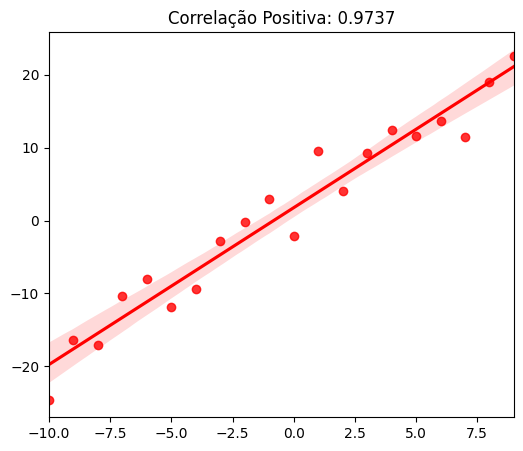

In [191]:
ax1 = plot_linear(2, 2, 3, -10, 10);

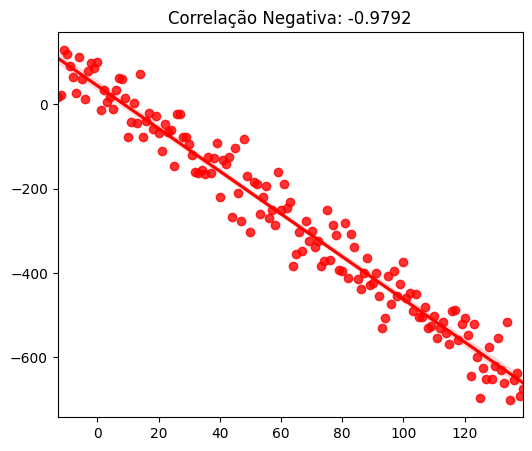

In [8]:
plot_linear(-5, 40, 50, -13, 140);

### 1.1.2. Rho de spearman

Robusto contra outliers e calculado em relação ao ranqueamento ou ordens dos dados, também mede relações lineares e não lineares.

$$r_s = 1 - \frac{6\sum{d^2}}{n^3 - n}$$

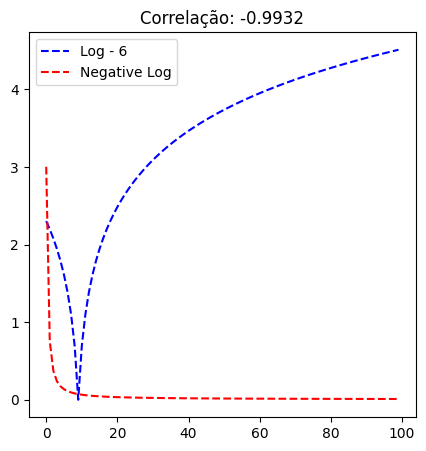

In [96]:
spearman_plot( 100, -3 );

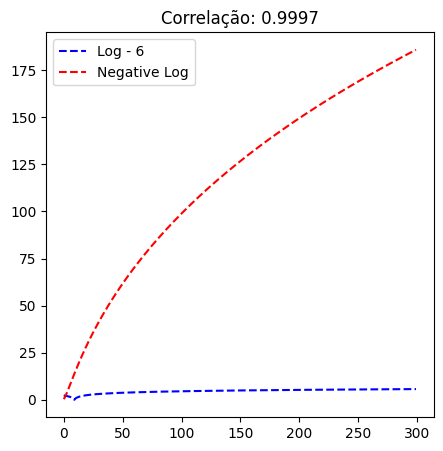

In [97]:
spearman_plot( 300, 3 );

### 1.1.4. V de Cramér

O V de cramér basicamente serve para calcular a correlação entre variaveis categoricas.

Existe a versão corrigida da fórmula de cramér que esta abaixo, k e r são as dimensões da matriz.

$$V = \sqrt{\frac{\varphi^{2}~ou~X^2 / n}{min(k-1, r-1)}}$$

$$\varphi^2 = max(0, \varphi^2 - \frac{(k-1) - (r-1)}{n-1}$$

$$cor~k = k - \frac{(k-1)^2}{n-1}$$

$$cor~r = r - \frac{(r-1)^2}{n-1}$$

In [226]:
df = DataFrame(CSV.File("data/store.csv"))
df = hcat(df[:, 2:3], df.StoreType )
df = rename(df, Dict("x1" => "State"));

# Rename Rows
df.Assortment = [replace(i, "a" => "BASIC") for i in df.Assortment];
df.Assortment = [replace(i, "b" => "EXTRA") for i in df.Assortment];
df.Assortment = [replace(i, "c" => "EXTENDED") for i in df.Assortment];

# Generate FataFrame
results = []
data = DataFrame()

for i in ["StoreType", "Assortment", "State"] 
    a = cramer_v( Array(df.StoreType), Array(df[:, i]) )
    b = cramer_v( Array(df.Assortment), Array(df[:, i]) )
    c = cramer_v( Array(df.State), Array(df[:, i]) )
    
    corr = Dict(i => [a, b, c])
    append!(results, corr)
end

df2 = DataFrame( results ) # Plotar um Mapa de Calor / Heatmap

,StoreType,Assortment,State
,Float64,Float64,Float64
1,1.00135,0.54068,1.00135
2,0.54068,1.0009,0.54068
3,1.00135,0.54068,1.00135


## 1.2. Dois Gráficos de Densidade

Hexagonal Binning relaciona as duas variaveis aleatorias normais em hexágonos, mesma coisa que o Histograma.<br>Kernel Density Estimate, Análogo análogo ao Hexagonal, porem em densidades com curvas. 

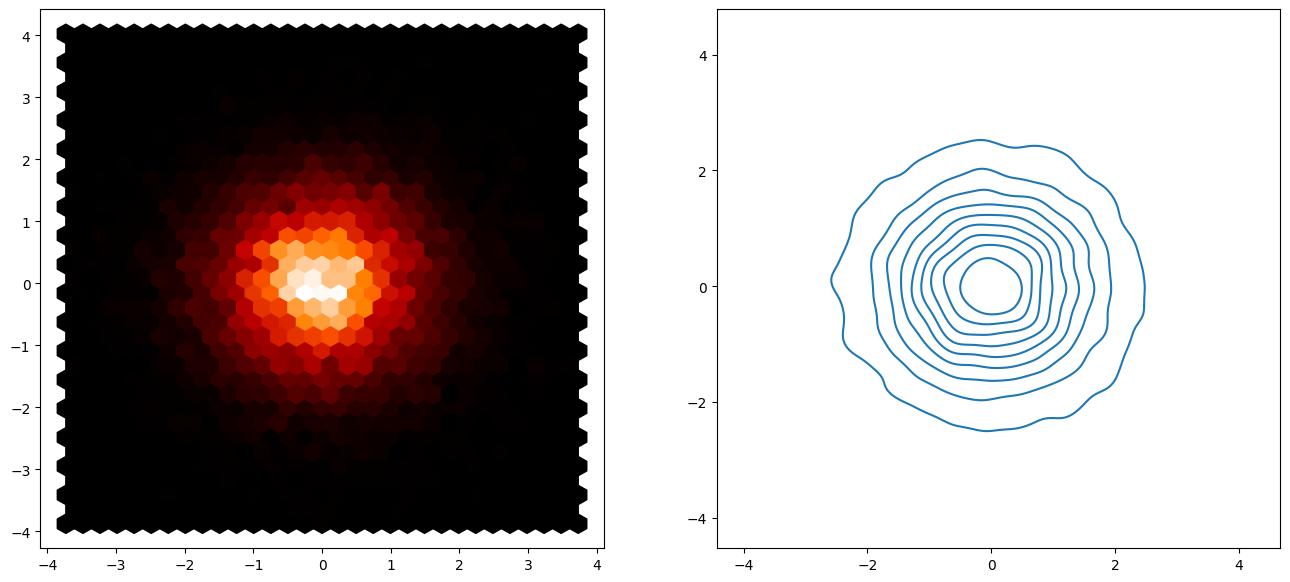

In [160]:
plot_density( 20000, 20000 )
plt.savefig("Density.png")

# Capítulo 2

## 2.0. Distribuição de Amostragem de uma Estatística

A distribuição de uma estatística amostral como a média costuma ser mais regular e campanular do que a distribuição dos proprios dados quanto maior a amostra em que a estatística se baseia. Além disso, quanto maior a amostra, mais estreita é a distribuição da estatística amostral. "Tende a Normal"...    

In [15]:
df = pd.read_csv("data/loans_income.csv");

In [16]:
sample = df.sample(1000)

sample_of_5 = pd.DataFrame( Dict("income" => [df["x"].sample(5).mean() for _ in 1:1000],
                                 "type" => "mean_of_5") )

sample_of_10 = pd.DataFrame( Dict("income" => [df["x"].sample(10).mean() for _ in 1:1000],
                                  "type" => "mean_of_10") )

sample_of_20 = pd.DataFrame( Dict("income" => [df["x"].sample(20).mean() for _ in 1:1000],
                                  "type" => "mean_of_20") )

result = pd.concat([sample, sample_of_5, sample_of_10, sample_of_20]);

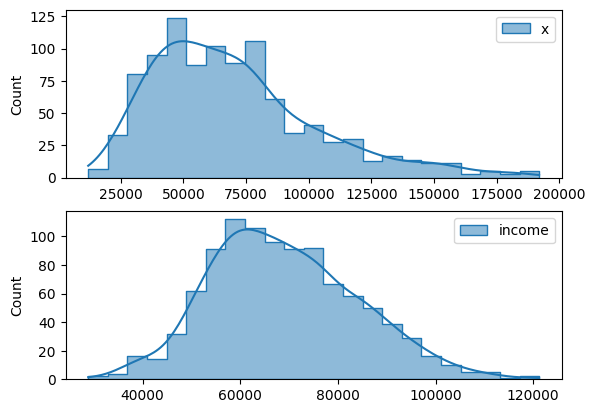

In [21]:
plt.subplot(2, 1, 1);
sns.histplot( sample, kde=true, element="step" );

plt.subplot(2, 1, 2);
sns.histplot( sample_of_5, kde=true, element="step" );

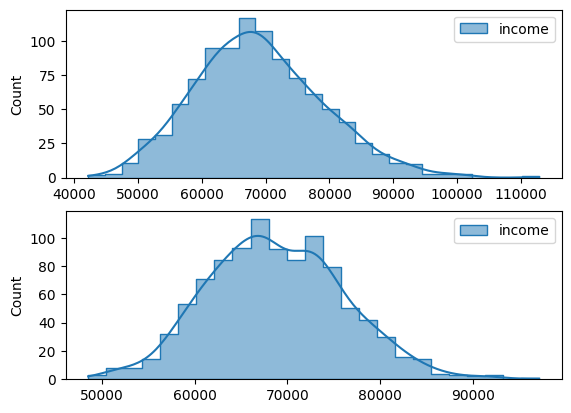

In [20]:
plt.subplot(2, 1, 1);
sns.histplot( sample_of_10, kde=true, element="step" );

plt.subplot(2, 1, 2);
sns.histplot( sample_of_20, kde=true, element="step" );

## 2.2. O Bootstrap

O bootstrap é uma forma eficiente e eficaz de estimar a distribuição amostral de uma estatística ou de parâmetros de modelo.<br>Conceitualmente pode-se imaginar o Bootstrap como uma replicação da amostra original várias vezes de modo a ter uma população hipotética que representa todo o conhecimento da amostra original só que maior.<br>Logo amostramos com reposição, dessa forma cria-se efetivamente uma população infinita na qual a probabilidade de um elemento ser extraído continua a mesma de extração por extração.<br>Com os resultados é possível encontrar um intervalo de confiança.

### 2.2.1. Sem Bootstrap

In [24]:
# Load and Prepare Dataset
df = DataFrame(CSV.File("data/diabetes.csv"));

x = df[:, 1:8];
x = hcat(x[:, 1], x[:, 2], x[:, 3], x[:, 4], x[:, 5], x[:, 6], x[:, 7]);

y = df[:, 9];

# Transform Variables
mms = prepro.MinMaxScaler()
x = mms.fit_transform( x );

# Split Dataset
x_train, x_test, y_train, y_test = model_selection.train_test_split( x, y, train_size=0.9 );

In [21]:
# Simple Logistic Regression
model = models.Sequential()
model.add( layers.Dense( 1, activation="sigmoid") )
model.compile( optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"])

In [22]:
history = model.fit( x_train, y_train, epochs=2000, verbose=0 );
test = model.evaluate( x_test, y_test );

3/3 [==============================] - 0s 2ms/step - loss: 0.5010 - accuracy: 0.7143


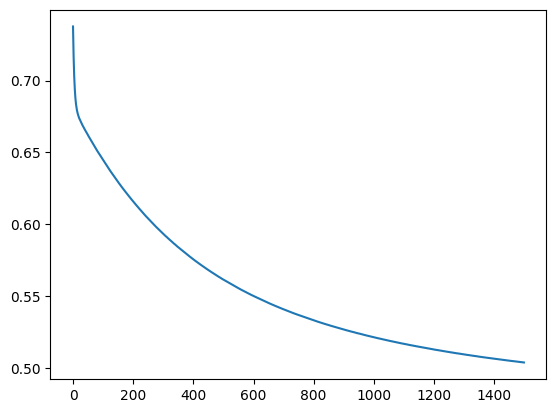

In [117]:
PyPlot.plot( history.history["loss"] );

####  Conclusão

In [116]:
@printf "Accuracy %.2f%%" maximum(history.history["accuracy"])*100

Accuracy if 77.71%

### 2.2.1. Com Bootstrap

In [25]:
# Configuration of Bootstrap
n_inter = 1000
n_size  = trunc(Int, (768 * 0.5))
stats   = []

# Set Up Data
df = hcat(df[:, 1], df[:, 2], df[:, 3], df[:, 4], df[:, 5], df[:, 6], df[:, 7], df[:, 8], df[:, 9])

for i in 1:n_inter
    sample = utils.resample( df, n_samples=n_size );
    y = sample[:, 9];
    x = sample[:, 1:8];

    x = mms.fit_transform( x );

    # Split Dataset
    x_train, x_test, y_train, y_test = model_selection.train_test_split( x, y, train_size=0.9 );

    model = tree.DecisionTreeClassifier() # Decision Tree, dont NN.
    model.fit( x_train, y_train )
    
    prediction = model.predict( x_test )
    score = metrics.accuracy_score( y_test, prediction )
    
    append!(stats, score)
end

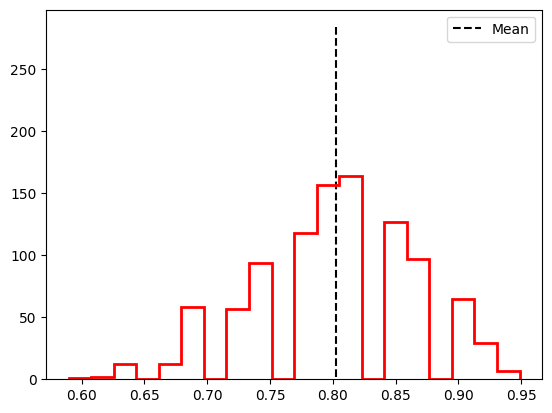

In [106]:
plot_bootstrap( stats, "step", "r" )

#### Conclusão

In [110]:
α = 0.95

p = ((1.0 - α)/2.0)*100
lower = np.percentile(stats, p)*100

p = (α + (1.0 - α)/2.0) *100
max = np.percentile(stats, p)*100

@printf "%.0f%% Confidence Intervals %.2f%% and %.2f%%" α*100 lower max

95% Confidence Intervals 66.67% and 92.31%

## 2.3. Distribuições

### 2.3.1 Distribuição Binomial

A distribuição Binomial é, vamos dizer assim uma continuação da distribuição de Bernoulli, onde a distribuição de Bernoulli trabalha somente com duas possibilidades, ou 1 geralmente chamado de evento de sucesso ou 0 de fracasso contendo as probabilidades desses eventos ao lado.

In [17]:
bernoulli = pd.DataFrame([["Azul", 0.35], ["Vermelho", 0.65]]);
bernoulli.columns = ["X", "Probabilidade"];
bernoulli

,X,Probabilidade
0,Azul,0.35
1,Vermelho,0.65


Formula da Distribuição Binomial

$$ P(r/n,p) = {{n}\choose{r}} \cdot p^r \cdot (1-p)^{n-r}, onde {{n}\choose{r}} = C_{nk} = \frac{n!}{r! \cdot (n - r)!}$$

 - r: Eventos de Interesse.
 - n: Repetições.
 - p: Probabilidade do Evento.

A média da distribuição binomial é dada pela formula: $n \cdot p$<br>A variáncia da distribuição binomial é dada pela formula: $\sqrt{n \cdot p \cdot(1-p)}$

Na formula da distribuição Binomial também pode se trabalhar com um conceito chamado de "Complementar", que nada mais é que uma forma mais rápida para calcular a binomial quando se tem um intervalo de eventos maior que um.
<br>$P(x >= k) = 1 - P(x < k)$
<br>$P(x > k) ~= 1 - P(x <= k)$
<br>$P(x <= k) = 1 - P(x > k)$
<br>$P(x < k) ~= 1 - P(x >= k)$<br><br>
Por exemplo se você for calcular um **n = 6** para uma possibilidade de, digamos **P( x >= 2 )**, você teria que calcular 5 vezes com a fórmula, logo<br>
$P(x=2) + P(x=3) + P(x=4) + P(x=5) + P(x=6)$<br><br>Porém, aplicando a regrazinha, inverte-se, logo:<br>
$1 - (P(x=0) + P(x=1))$

In [16]:
P(r, n, p) = (factorial(n) / (factorial(r) * factorial(n-r))) * (p^r) * ((1 - p)^(n-r));

Qual é a probabilidade de sair 3 caras em 4 jogadas e a probabilidade de cada cara é $\frac{1}{2}$ 

$$ P(2 / 4,\frac{1}{2}) = 6 \cdot (\frac{1}{2})^2 \cdot (\frac{1}{2})^2 = \frac{6}{16}$$

In [18]:
@printf "A probabilidade de sair três caras em quatro jogadas é: %.3f%% " P(2, 4, .5)*100

A probabilidade de sair três caras em quatro jogadas é: 37.500% 

Qual é a chance de 3 pessoas que eu ligar das 10 entrarem em churn sabendo que a probabilidade de uma pessoa em churn na base de dados é 0.15%? 

In [19]:
@printf "A probabilidade de 3 das 10 pessoas ligadas entrarem em churn é: %.3f%%" P(3, 10, .15)*100

A probabilidade de 3 das 10 pessoas ligadas entrarem em churn é: 12.983%

Confome a probabilidade tende a o equilibrio, ou seja, .5% de cair cara ou coroa, logo a distribuição parece uma Normal.

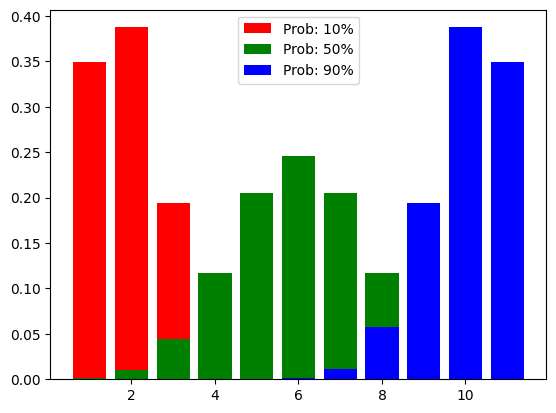

In [194]:
plot_three_bn( [0.1, 0.5, 0.9], ["r", "g", "b"], ["Prob: 10%", "Prob: 50%", "Prob: 90%"] )
plt.savefig("Binomial.png")

### 2.3.2 Distribuição de Poisson

Alta concentração de eventos próximos ao eixo y, uma das principais características é que não tem repetições como na distribuição binomial trabalha em um intervalo continuo.<br>Ex: Em um estudo de chuva ou cliques em um site, no exemplo da chuva, qual é a chance de uma chuva, só que não existe o evento "não chuva" entre duas chuvas.

Imagine um intervalo, que começa e 0 até uma variável W por exemplo. E eu divido em **n** intervalos muito pequenos, onde n tende ao infinito., logo a probabilidade está tendendo a 0 pois existem n intervalinhos, com essa quantidade de intervalos, virou uma binomial, ou seja, choveu ou não por exemplo.

$$P(r/\frac{\lambda}{r}, n) = \lim_{n\to\infty} (\frac{\lambda}{n})^r . (1-\frac{\lambda}{n})^{n-r}. \frac{n!}{r!(n-r)!}$$

Distribuição de Poisson, logo $\lambda$ (Quantidade de Chuva) = p * n, então p = $\frac{\lambda}{n}$. No Limite que n tende ao infinito, o produto de **n** e **r** não vai mudar pois **r** sempre vai ficar menor e **n** sempre vai ficando maior.

$$P(r/\lambda)= \frac{e^{-\lambda} \cdot \lambda^{r} }{r!}$$

A média e a variância da distribuição binomial é dada pelo: $\lambda$<br>E o Desvio Padrão é $\sqrt{\lambda}$

In [11]:
P(λ, r) = np.e^-λ * λ^r / np.math.factorial(r);

Dado que eu esperava em média 35 carros entrando no shopping, qual a probabilidade de aparecer 20?

In [15]:
@printf "A probabilidade de somente uma chuva no mês é de: %.3f%%" P(35, 20)*100

A probabilidade de somente uma chuva no mês é de: -0.000%

In [140]:
# Julia tem problema com elevar x a o espoente y
function f(x, y)
    [x*=x for _ in 1:y]
end
f(35, 20)

20-element Vector{Int64}:
                 1225
              1500625
        2251875390625
  6616016035436858689
  7865930784382691969
 -4822766768660441855
 -1652024524321314303
   450275795304469505
 -6392656039275616255
  7551947002216534017
  3654036140188672001
  8358544585278177281
  4785494631104806913
 -2679742982427181055
  2893676706708193281
  8010019347241369601
   -48246705104617471
 -5786811055723249663
 -8394158839848501247
   541221425122377729

Logo em Python, aplicando a mesma função irá retornar a probabilidade de 0.0019

In [14]:
@printf "A probabilidade de somente uma chuva no mês é de: %.3f%%" P(5, 1)*100

A probabilidade de somente uma chuva no mês é de: 3.369%

In [895]:
x = ss.poisson.rvs(2, size=500);

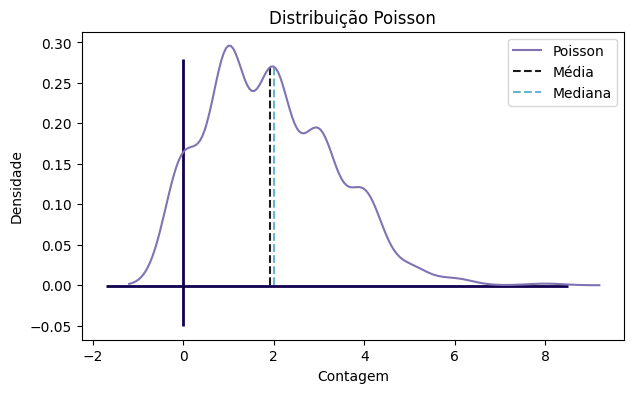

In [896]:
plot_poisson( x, "m" )

### 2.3.5 Distribuição Normal

A distribuição Normal e simétrica a média e as outras distribuições são geralmente moldadas de forma normal. Em uma distribuição normal 68% dos dados ficam dentro de um desvio-padrão da média e 90% dos dados em dois desvios-padrões.<br>A diferença entre a distribuição normal das outras distribuições (binomial e poisson) é que na noção de distribuição discreta e continua, ambas são distribuições discretas pois as possibilidades dos eventos eram discretos, agora x pode assumir uma probabilidade, logo a função é chamada de densidade de probabilidade.<br>Onde para calcular a área em baixo da curva usa-se a ferramenta de Integral. $\int_{0}^{1}f(x) \,dx$<br>Ou utiliza a tabela da normal.<br>
Na Integral, o primeiro valor de baixo (0) é o primeiro valor da esquerda para direita na distribuição, e o valor de cima (1) é justamente até aonde vai a área.

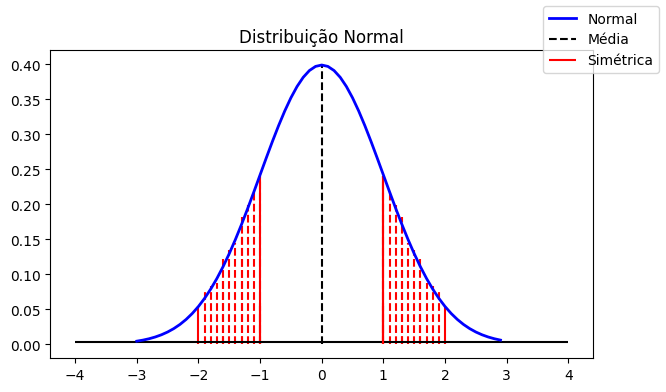

In [97]:
range = np.arange(-3, 3, 0.1)
plot_normal( range, true )

Função densidade de probabilidade

$$f(x) = \frac{1}{\sqrt{2 \pi}\sigma} \cdot e^{\frac{-(x-\bar{x})^2}{2 \sigma^2}}$$

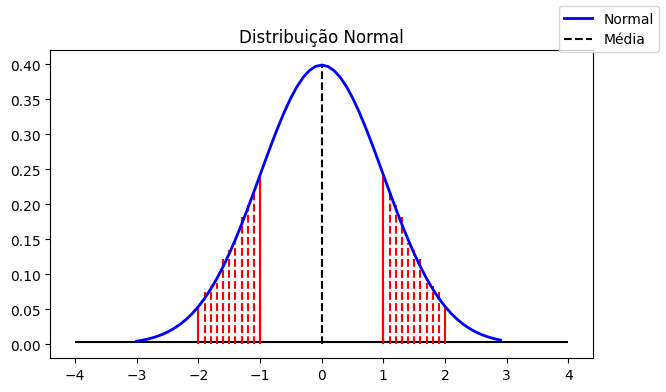

In [290]:
plot_normal( range, true );

Como a variável x é continua, sendo assim pode assumir infinitos valores, e tamém toda a area da curva gaussiana é 1*.<br>
Logo para calcular a área entre 1 e 2 da normal:

$$P = \int_{1}^{2}\frac{1}{\sqrt{2\pi}\sigma} \cdot e^{\frac{-(x-\bar{x})^2}{2 \sigma^2}}\,dx$$

### 2.3.6. QQ Plot

QQ plot nada mais é que um plot para visualizar como está o shape da distribuição, se tem skewness ou kurtosis.<br>
**Skewness:** Geralmente se fala em Skewness quando a distribuição está tombada para algum dos lados, uma Skewness **positiva** significa que a distribuição está mais deslocada para a esquerda, e uma skewness **negativa** quando está mais deslocada a direita, o exemplo na imagem da distribuição exponencial abaixo.<br>
**Kurtosis:** Mede o quanto a distribuição está esticada para cima ou com formação de longas caldas, quando mais pontuda, maior a kurtosis e quando mais normal, menor a kurtosis, o exemplo é a distribuição exponencial que tem uma certa kurtosis positiva.<br>

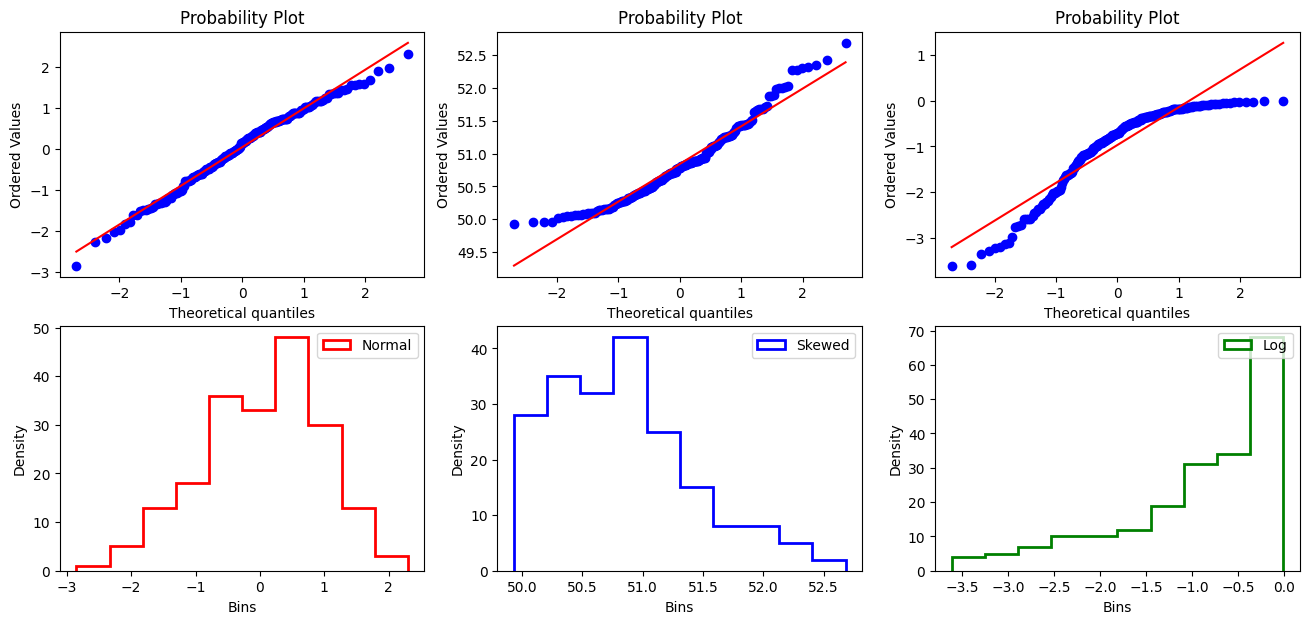

In [161]:
# Existe um pacote chamado Plots que faz a mesma função de plotar o QQ Plot.
x = np.random.randn(200);
y = [log(abs(p)) for p in np.random.random(200)];
z = ss.skewnorm.rvs(a=10, loc=50, size=200)

plot_qq(x, y, z, "step")
plt.savefig("QQplot.png")

### 2.3.7. Normalização

A normalização é um conceito utilizado principalmente para treinar modelos de machine learning que consiste em movimentar a distribuição para o centro com média 0, resumidamente subtrair a média de todos os dados.<br>
Se reparar nos gráficos da distribuição normal, logo a média já está no 0.<br>
Se eu somar a média da distribuição em toda a distribuição ela vai ser deslocada para direita, se subtrair ela é deslocada a esquerda.<br>
E quando se divide por $\sigma$, logo a média e 0 e a dispersão é 1.

Quando esta normalizada é possível utilizar a tabela da normal padrão paara calcular a área em baixo da curva.<br>Exemplo, dado uma média de 200 e desvio padrão de 4, qual é a $P(x>210)$?<br>
- 1° Passo, calcular o Z, que nada mais é que subtrair a média e dividir pelo desvio padrão.<br>
Ou seja $z = \frac{210 - 200}{4} = 2.5$, esse é o resultado que deve ser encontrado a área, para isso so checara tabela, onde são 2,5 os dois primeiros números e 0 o terceito número, o resultado vai ser $0.4938$<br>
- 2° Passo, Realizar a seguinte expressão $(.5 - .4938) \cdot 100$<br>
Subtrair pela metade da distribuição normal o resultado para pegar somente a probabilidade de ser maior que 210, e multiplicar por 100 para deixar em porcentagem, logo o resultado final é: $0.62%$.

In [3]:
Image = pyimport("IPython.display");
Image.Image()

### 2.3.8 Distribuição Exponencial

Usa o mesmo parâmetro $\lambda$ da distribuição de Poisson, esse parâmetro permanece constante ao longo do período sendo considerado.<br>É utilizado na engenharia para modelar falhas , tempo de visitas de sites, etc.

In [870]:
x = ss.expon.rvs( 0.2, size=1000);

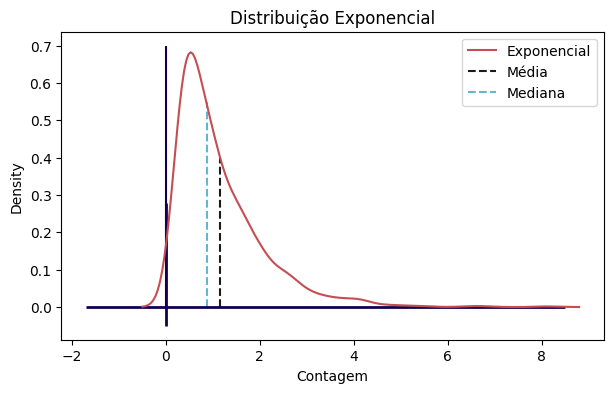

In [871]:
plot_exp(x, "r")

### 2.3.9 Distribuição Weibull

É uma extensão da distribuição Exponencial, na qual a taxa de evento pode mudar de acordo ocm um "parâmetro de forma" β<br>
Se β > 1, a probabilidade de um evento aumenta com o tempo.<br>
Se β < 1, a probabilidade de um evento diminui com o tempo.<br>Quando o $\alpha$ da distribuição de Weibull é 1, retorná a distribuição exponencial.<br>
Sendo assim, pode ser utilizada na análise de sobrevivência & confiabilidade, e sua função é:

Comulativa: $$f(x, \alpha, \beta) = 1 - e^{-(\frac{x}{\beta})^\alpha}$$

Densidade de Probabilidade: $$f(x, \alpha, \beta) = \frac{\alpha}{\beta^{\alpha}} \cdot x^{a -1}\cdot e^{-(\frac{x}{\beta})^{\alpha}} $$

In [276]:
f(x, a, b) = (a / (b^a)) * (x^(a-1)) * ℯ^(-(x/b)^a)
f(3, 3, 3)

0.36787944117144233

In [275]:
20^30 # não é possível utilizar numéros grandes pois o mesmo problema.

-8070450532247928832

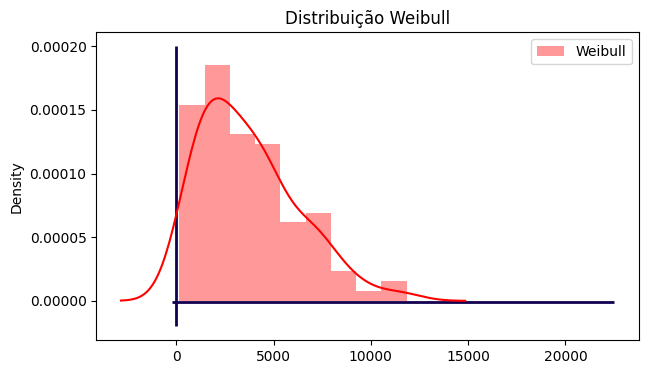

In [86]:
x = ss.weibull_min.rvs(1.5, scale=5000, size=100)
plot_wei(x, "r")

# Capítulo 3

## 3.1. Teste de Hipóteses

Os testes de hipóteses são um dos pilares da estatística, o objetivo desses testes são rejeitar ou confirmar hipóteses, os testes de hipóteses também são chamados de testes de significância, em outras palavras, nos permite rejeitar ou não uma hipótese estatística com base nos resultados de uma amostra.
Os testes de hipóteses são importantes pois dado a tendência humana em reagir a eventos incomuns e interpretá-los como algo significativo e real, em experimentos requer provas de que esses eventos são realmente diferentes e não eventos aleatórios.

 - **Hipótese Nula**: Nada mais é que o esperado, ou seja, o que já está acontecendo, o comum.
 - **Hipótese Alternativa**: O fenômeno que está sendo analisado, o contraponto da hipótese nula.
 - **Teste Unilateral**: Ou também chamado de teste Unicaldal, onde as possibilidades estão em uma direção.
 - **Teste Bilateral**: Ou também chamado de teste Bicaldal, onde as possibilidades estão em duas direções.
 - **Nível de Significância**: É a probabilidade máxima permissível para cometer um erro de tipo I, em outras palavras é o limite para aceitar ou rejeitar a hipótese, esses limites estão entre (1%, 5% e 10%), também chamado de α.
 - **P-Valor**: Trabalha junto com o Nível de Significância e com a Ho sendo verdadeira, nada mais é que o valor para concluir o teste de hipótese, logo ele evidência que:
     - Se o p-valor for menor ou igual ao nível de significância, rejeita-se a Hipótese Nula, pois realmente surtiu efeito o teste.
     - Se o p-valor for maior que o α, aceita a Hipótese Nula, por não ter evidências o suficiente para aceitar a Hipótese Alternativa.
 - **Teste Estatístico**: Uma operação com dois grupos, ex subtrair a média de dois grupos.

In [301]:
df = DataFrame(CSV.File("data/web_page_data.csv"));

In [50]:
mean_page_a = np.mean(df[df.Page .== "Page A", 2])
mean_page_b = np.mean(df[df.Page .== "Page B", 2])

@printf "Diferença do tempo de sessão entre a página A e B: %.2f%%" (mean_page_b - mean_page_a)*100

Diferença do tempo de sessão entre a página A e B: 35.67%

Agora a pergunta é: **Esse tempo foi gerado pelo acaso ou pela característica da página?**

Existem várias ferramentas para validar hipóteses, como o teste de permutação, teste t...

$$H_o: \text{A média do tempo de sessão para a página A é maior ou igual que a B}$$
$$H_a: \text{A média do tempo de sessão para a página A é menor que a B}$$
$$\alpha = .05$$

## 3.2. Reamostragem 

### 3.2.1. Teste de Permutação em tempos de sessão.

O teste de permutação nada mais é que um teste para verificar se tem realmente um significado estatístico.<br>
1. Separar o grupo de controle e o grupo de tratamento, o de tratamento que vai ser o grupo que irá receber o teste.
2. Depois do teste, calcular alguma estatística, exemplo a média da diferença dos dois grupos.
3. Juntar em uma base de dados o grupo de controle e o grupo de tratamento.
4. Amostragem aleatória de diferentes indivíduos dessa base de dados e calcular a mesma estatística e armazenar o resultado.
5. Montar uma distribuição com os resultados.
6. Calcula a quantidade de vezes que os valores maior que a média sairam durante o processo de amostragem e divide pela quantidade de vezes que foi realizado a amostragem, logo esse é o p-valor, o valor da aleatoriedade na escolha dos grupos.

In [219]:
diff = [permutation( df.Time, 21, 15 ) for _ in 1:1000];
p_valor = py"test"(diff, diff_mean);

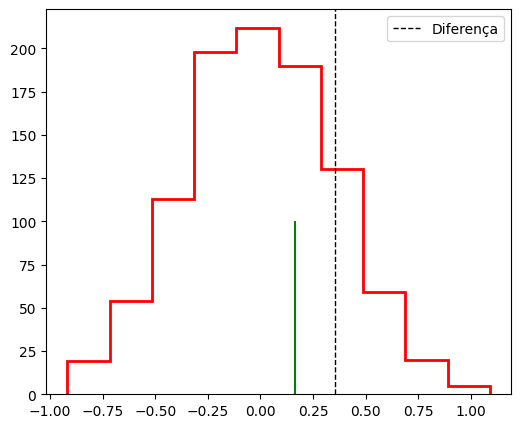

In [246]:
plot_permutation(diff, diff_mean, "k", "g");

In [302]:
@printf "Logo a quantidade de vezes que excedeu o limite foi de %.2f%%\nEntão aceita a Ho." p_valor*100

Logo a quantidade de vezes que excedeu o limite foi de 15.70%
Então aceita a Ho.

### 3.2.2. Teste de permutação em taxas de conversão.

Nesse exemplo existe +20000 visualizações de um determinado preço e foi mensurado a quantidade de cliques em ambos os preços.<br>

In [118]:
DataFrame(Dict("Resultado" => ["Preço A", "Preço B"], "Cliques" => [200, 182], "No Cliques" => [23539, 22406]))

,Cliques,No Cliques,Resultado
,Int64,Int64,String
1,200,23539,Preço A
2,182,22406,Preço B


In [122]:
obs_diff = ((200/(23539+200)) - (182/(22406+182)))*100
@printf "A diferença do Preço A e do Preço B é: %.3f%%" obs_diff

A diferença do Preço A e do Preço B é: 0.037%

$$H_o: \text{Não há diferença entre as taxas de A e B}$$
$$H_a: \text{A conversão da taxa A é diferente em relação a taxa B}$$
$$\alpha = .05$$ 

Uma das formas de responder essa pergunta é realizando um teste de permutação.
- Crie um vetor com todos os dados, ou seja, 45945 vezes foram realizados 0 cliques, logo um vetor com 45945 zeros, e um vetor com 382 que tiveram 1 clique, logo esse vetor vai ter um tamanho de 46327, contendo o total de zeros e o total de 1 cliques.
- Realize o teste de permutação $n$ vezes.

In [228]:
a = append!(vec(zeros(1, (45945))), vec(ones(1, 382)));
per = [(permutation( a, 23739, 22588 )*100) for _ in 1:1_000 ];

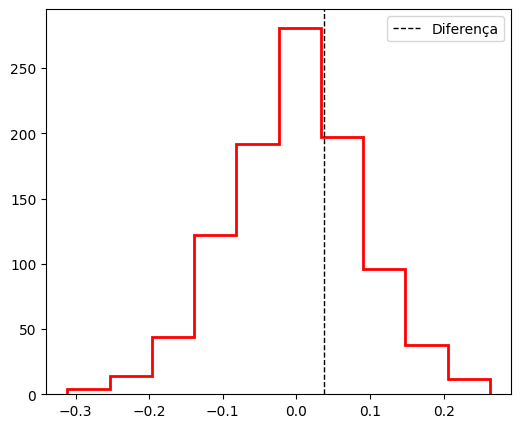

In [293]:
plot_permutation( per, obs_diff, "k", "r" );

In [304]:
p_valor = py"test"(per, obs_diff);

In [308]:
@printf "Em relação aos preços, com uma significância de 0.05, o p-valor foi: %.2f%%\nEntão aceita a Ho." p_valor*100

Em relação aos preços, com uma significância de 0.05, o p-valor foi: 32.60%
Então aceita a Ho.

In [314]:
# Outras formas
chi2, p_value, df, _ = ss.chi2_contingency([[200, 23739 - 200], [182, 22588 - 182]])
@printf "Chi2: %.2f\nP-Value: %.2f" chi2 p_value

Chi2: 0.15
P-Value: 0.70

## 3.3. Teste T de Student

O teste T de Student nada mais é que um teste de comparação de dois grupos em relação a sua média.<br>Nas quais os dados são numéricos, mas para que seja utilizado é necessário usar uma forma padronizada de estatística de teste.

Esse teste também é uma aproximação para o teste de permutação, devido que o teste de permutação na época de sua implementação era muito custoso.
Para utilizar o teste t, é necessário alguns passos.
- 1. Calcula a média de ambos os grupos.
     - A diferença entre as duas médias é significativa? <br><br>
- 2. Elevar os dados de ambos os grupos por exemplo o grupo $X$ e o grupo $Y$ e somar $\sum{X^{2}}$, $\sum{Y^{2}}$ os grupos ao quadrado.
- 3. Calcula a variância de ambos os grupos (ou o std).
- 4. Coloca na fórmula do teste t, com o resultado da fórmula, localiza na tabela da distribuição t.

Obs: Existem várias formulas para a variância conhecida, não conhecida, amostras dependentes, idependentes e assim vai. 

Para aplicar o teste t ou Welch's t-test, quando a variância populacional é desconhecida em amostras idependentes (Com ou sem o N-1):
$$t_o = \frac{\bar{x_a} - \bar{x_b}}{\sqrt{\frac{(n-1)s^{2}_1 + (n-1)s^{2}_2}{n_1 + n_2 - 2} \cdot \sqrt{\frac{n_1 + n_2}{n_1 \cdot n_2}}}}$$<br>
Welch's T-Test: $$t' = \frac{\bar{x_a} - \bar{x_b}}{\sqrt{\frac{s^{2}_1}{n_1} + \frac{s^{2}_2}{n_2}}}$$

Essa fórmula é a mesma do $t_o$, logo retorna quase o mesmo resultado do método ttest_ind do scipy que esta armazenada em u script separado na pasta de scripts.<br>Esse resultado é a **Estatística T**, logo precisa calcular ou ir na tabela t-student com os graus de liberdade ($n_1 + n_2 - 2$) e o nível de significância.<br>Por exemplo se os graus de liberdade for 20 e o nível de significância for 0.05%, na tabela o p-valor vai ser aprx: 0.80.***

In [316]:
include("../scripts/t_test.jl");
@printf "Estatística T: %.4f" t_test( df[df.Page .== "Page A", 2], df[df.Page .== "Page B", 2], true )

Estatística T, -1.0823

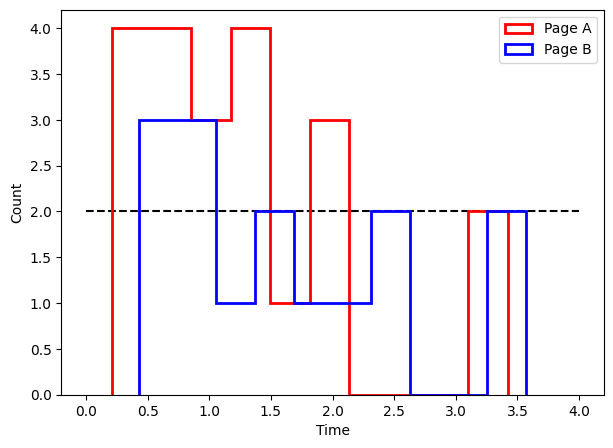

In [5]:
plot_page_diff()

In [155]:
info = pages()
list = ["less", "two-sided"]

for i in list
    t_test_ss = ss.ttest_ind( df[df.Page .== "Page A", 2], df[df.Page .== "Page B", 2], equal_var=false, alternative=i )
    if i == "less"
        @printf "P-Value One Sided %.3f\n" t_test_ss[2]
        @printf "T-Statistic: %.3f\n" t_test_ss[1]
    else
        @printf "\nP-Value Two Sided %.3f\n" t_test_ss[2]
        @printf "T-Statistic: %.3f\n" t_test_ss[1]
    end
end

P-Value One Sided 0.141
T-Statistic: -1.098

P-Value Two Sided 0.282
T-Statistic: -1.098


In [172]:
gl = glass_delt( info["mean_a"], info["mean_b"], info["std_a"] )
r  = pearson_r( t_test_ss[1], 34 )
d  = cohen_d( info["mean_a"], info["mean_b"], info["std_a"], info["std_b"] )
g  = hedge_g( d, info["n_a"], info["n_b"] )

@printf "Glass ◭: %.4f" gl
@printf "\nPearson ρ: %.4f" r
@printf "\nCohen's d: %.4f" d
@printf "\nHedge's g: %.4f" g

Glass ◭: -0.4131
Pearson ρ: 0.1851
Cohen's d: -0.3869
Hedge's g: -0.3761

 - Glass ◭: É a diferença média entre os dois grupos dividido pelo desvio padrão do grupo controle.
 - Pearson ρ: Pearson / Rosenthal serve para calcular a correlação utilizando o P Value e os Graus de Liberdade.
 - Cohen's d: Diferença das médias, é uma formula do "tamanho do efeito", que resumidamente mede o tamanho das associações entre as variáveis ou da diferença entre as médias dos grupos.
 - Hedge's g: Correção do D de Cohen.

Glass: $gl = \frac{\bar{x}_1 + \bar{x}_2}{Sd_1}$ <br><br>
Pearson: $r = \sqrt{\frac{t^{2}}{t^{2} + df}}$ <br><br>
Cohen's d: $d = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{sd_1^{2} - sd_2^{2}}{2}}}$ <br><br>
Hedge's g: $g = d \cdot 1 - \frac{3}{4 \cdot (n_1 + n_2 - 9)} $

## 3.4. Teste de Qui Quadrado

Esse teste de hipótese pode ser utilizado em intervalos, o uso mais comum é em tabelas de contingência também chamadas de tabelas de frequência, onde existem variáveis qualitativas que na maioria das vezes não possuem uma ordem, por exemplo, das pessoas que não fazem exercícios e das pessoas que fazem exercícios, quantas delas tem um sono bom e quantas tem um sono ruim?<br>A distribuição qui quadrado é determinado pelos graus de liberdade que esta relacionado ao número de colunas na Tabela.<br>
 - Se a frequência estiver entre 5 e 10, é necessário uma correção chamada correção de Yates. 

Passos para montar um teste de qui quadrado<br>
1. Calcular o valor esperado em relação ao teste
    - O exemplo do Livro é a média dos cliques e não cliques.<br><br>
2. Calcular os residuos de Pearson (X_observado e X_esperado).
$R = \frac{X_o - X_e}{\sqrt{X_e}} $ que retorna as contagens diferentes.<br><br>
3. Calcular a estatística de qui quadrado.
$\xi =  \sum_{i}^{r}\sum_{j}^{c}R^{2}$<br><br>
4. Calcular o grau de liberdade que é $gl = k - 1$ onde k é o n° de categorias.
Exemplo do Livro em três Headlines (Teste A, B, C)<br>

In [431]:
df = DataFrame(Dict("Teste" => ["Headline A", "Headline B", "Headline C"], "Click" => [14, 8, 12], "NoClick" => [986, 992, 988]))

,Click,NoClick,Teste
,Int64,Int64,String
1,14,986,Headline A
2,8,992,Headline B
3,12,988,Headline C


In [283]:
@printf "Valores Esperados: \n  Média de Cliques: %.4f\n  Média de Não Cliques C: %.4f" ((14+8+12)/3) ((986+992+988)/3)

Valores Esperados: 
  Média de Cliques: 11.3333
  Média de Não Cliques C: 988.6667

Logo com essa tabela em porcentágem com o resultado do P valor você consegue chegar em uma análise mais precisa que pode ser reportada, por exemplo a coluna x é tantos porcento melhor que a coluna y.

Tabela já com o cálculo dos resíduos de pearson: 

In [664]:
df = DataFrame(Dict("Teste" => ["Headline A", "Headline B", "Headline C"], "Click" => [0.792, -0.990, 0.198], "NoClick" => [-0.084, 0.106, -0.021]))

,Click,NoClick,Teste
,Float64,Float64,String
1,0.792,-0.084,Headline A
2,-0.99,0.106,Headline B
3,0.198,-0.021,Headline C


Mesma lógica do teste T, tem que ir na tabela da distribuição qui quadrado com os graus de liberdade que são 2 e localizar o valor mais proximo de 1.66, que esta entre 0.50 na tabela.<br>Mas existem já softwares que fazem esse cálculo automaticamente retornando já os resultados, por isso você não precisa decorar ou saber fórmulas, basta entender e onde aplicar esses testes estatísticos.

In [300]:
@printf "Estatística de Chi Quadrado: %.3f" sum(df.Click.^2)+sum(df.NoClick.^2)

Estatística de Chi Quadrado: 1.665

Uma forma gráfica de analisar um teste de chi quadrado é usando o grafico de barras agrupados, onde metade de uma barra é uma porcentagem e a outra metade é a outra porcentagem da tabela de frequência das variáveis.

### 3.4.1. Teste Qui Quadrado com permutação 

1. Construa um vetor com os dados do teste (34 clicks e 2966 não clicks)
2. Embaralhe e pegue três amostras separadas de 1.000 valores e conte quantos clickes conseguiu.
3. Calcule o R entre as amostras e os dados esperados.
4. Repita o passo 2 e 3 n vezes.
5. Quantas vezes os valores do processo de reamostragem são maiores que os valores observados? 

In [751]:
info = permutation_chi2_julia()
chi2obs, p_value, _ = ss.chi2_contingency( df )

@printf "Chi2 Observado: %.4f\nReamostragem P-Valor: %.4f" info[2] info[1]
@printf "\n\nChi2 Observado: %.4f\nScipy P-Valor: %.4f" chi2obs p_value

Chi2 Observado: 1.6659
Reamostragem P-Valor: 0.8800

Chi2 Observado: 1.6659
Scipy P-Valor: 0.4348

## 3.5. Teste Exato de Fisher

Resumidamente é uma opção do teste de chi quadrado onde realmente tenta ser o mais exato posssível e determinar exatamente o quão extremo é o resultado calculando não apenas uma probabilidade, mas todas as probabilidades.<br>Exemplo, se quatro pessoas compraram a camiseta azul e uma pessoa comprou a camiseta vermelha, sabendo que no estoque tem $n$ cores, qual é a probabilidade de sair uma camiseta vermelha por primeiro e quatro camisetas azuis nas proximas quatro compras, qual é a probabilidade de uma camiseta azul, uma vermelha e três azuis... ou seja, qual é a probabilidade de todas as ordens das compras dessas cinco camisetas.

Exemplo do Livro, no Python o método fisher_exact aceita somente uma matriz 2x2.

In [490]:
list = [[[14, 12] [986, 988]],
        [[14, 8] [986, 992]],
        [[8, 12] [992, 988]]];

[ss.stats.fisher_exact(k) for k in list]

3-element Vector{Tuple{Float64, Float64}}:
 (1.1690331304935768, 0.8440019335625599)
 (1.7606490872210954, 0.28359694839847466)
 (0.6639784946236559, 0.5012686435809882)

1. Indicado para ser utilizado quando as amostras são pequenas (Menor que 5).

## 3.6. Teste ANOVA

Também chamada de análise de variância, serve para compararr a média entre três ou mais grupos, por exemplo o test t é para dois grupos, logo se estiver trabalhando com mais grupo, a anova é o recomendado.<br>
Alguns requisitos para a o teste da Anova:<br>
1. Amostras Idependentes.
2. A distribuição tem que ser normal.
3. Quando a variavel dependente é quantitativa.
4. Caso o p-valor for <= $\alpha$ teve um efeito entre as $n$ médias, mas o teste aponta que pelo menos um dos grupos teve uma diferença, não aponta qual grupo teve uma diferança, logo é necessário uma continuação dos testes de hipóteses como o Tukey ou multiplos testes t.
5. Para evitar futuros erros, existem algumas correções para o teste ANOVA como a correção de Bonferroni e a correção de Sídak.

- **Variação entre grupos**: Avaliação dos dados em relação a média da amostra.
- **Variação dentro dos grupos**: Avaliando os dados em relação a média dos vários grupos.

Outros Testes:<br>
 - Kruskal-Wallis É um teste não paramétrico (N requer presupostos que a distribuição é Normal), logo requer um teste de normalidade antes como o QQ Plot ou o Shapiro para ver se você deve utilizar o anova ou o kruskal.
 - Teste U de Mann-Whitney um teste parecido com as mesmas especificaçãoes dos outros, porém pode ser utilizado com um tensor.
 - Bonferroni e Sindak são correções para os testes da Anova.

In [4]:
rg1 = np.arange(-5, 5, 0.1)
rg2 = np.arange(-7, 3, 0.1)
rg3 = np.arange(-6, 4, 0.1)
rg4 = np.arange(-3, 7, 0.1)
rg5 = np.arange(-10, 0, 0.1);

Quatro distribuições ipotéticas para o exemplo.
1. Essas distribuições seguem uma normal, logo é possível utilizar o ANOVA.

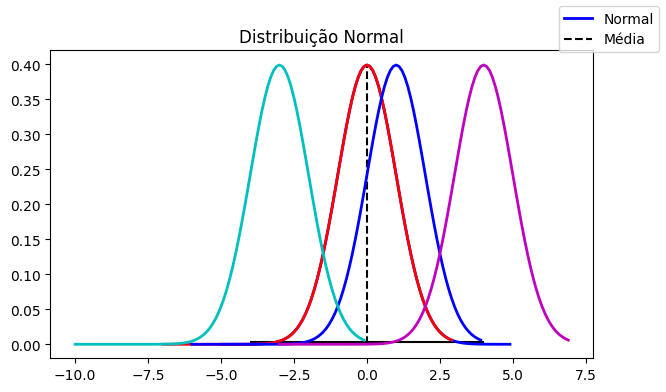

In [52]:
plot_normal_plus( rg1, rg2, rg3, rg4, rg5 );

Nesse exemplo acima, visualmente a amostra representada pela distribuição em azul, parece ter dados não tão importantes quanto por exemplo a distribuição em azul marinho em relação a todos os dados. (não é 100% uma normal mas deu de entender haha)

$H_o$ **= Não há diferenças estatisticamente significantes entre as médias dos grupos.**<br>
$H_a$ **= As médias dos grupos são diferentes.**<br>
$\alpha$ **= 0.05**

Antes de realizar o teste anova, é importante checar se as distribuições são normais, existem várias técnicas de fazer essa análise, como o qq plot, shapiro, etc, eu ja mostrei o QQ-plot, então vou mostrar o teste de shapiro com o Scipe.

In [20]:
_, p = ss.shapiro( [99 77 83 98 43 86 83 95 94 50] )
@printf "A Distribuição dos dados acima NÃO seguem uma distribuição normal, com um p-valor de: %.4f" p

A Distribuição dos dados acima NÃO seguem uma distribuição normal, com um p-valor de: 0.0301

In [21]:
df = DataFrame(CSV.File("../data/four_sessions.csv"))
#df1 = pd.read_csv("data/four_sessions.csv");

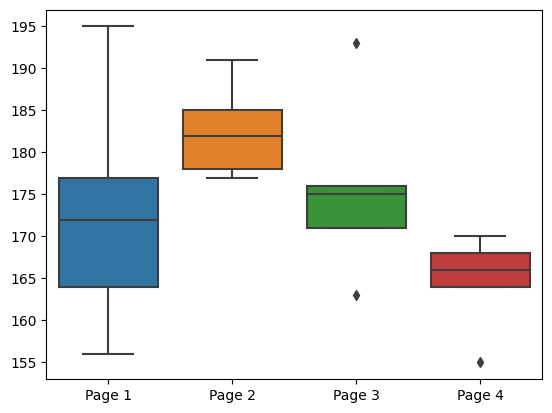

In [13]:
sns.boxplot( df.Page, df.Time );

Antes vamos analisar se realmente as distribuições são normais com o teste de shapiro.

In [56]:
@printf "Seguindo o teste de Shapiro para as distribuições"
for i in collect(1:4)
    @printf "\nPagina: %g -> P-Valor: %.4f" i ( ss.shapiro( df[df.Page .== "Page " * string(i), 2] ) )[2]
end

Seguindo o teste de Shapiro para as distribuições
Pagina: 1 -> P-Valor: 0.8732
Pagina: 2 -> P-Valor: 0.6350
Pagina: 3 -> P-Valor: 0.5653
Pagina: 4 -> P-Valor: 0.3299

Logo as distribuições são Normais.

In [290]:
f_stats, p_value = ss.f_oneway( df[df.Page .== "Page 1", 2], df[df.Page .== "Page 2", 2], df[df.Page .== "Page 3", 2], df[df.Page .== "Page 4", 2] )
@printf "Estatística F: %.4f\nP-Valor: %.4f" f_stats p_value

Estatística F: 2.7398
P-Valor: 0.0776

### 3.6.1. Teste Kruskal - Wallis

Para um exemplo que não tem uma Distribuição Normal, utiliza-se o teste de Kruskal, **porém**, caso caso você tenha uma amostra muito maior que +/- 30 linhas no dataset, a distribuição ja vai estar mais parecida com uma normal, e ambos os testes de anova e kruskal vão dar parecidos.  

In [136]:
a = [floor(np.random.uniform( 20, 100 )) for _ in collect(0:39)]
b = [floor(np.random.uniform( 20, 100 )) for _ in collect(0:39)]
c = [floor(np.random.uniform( 20, 100 )) for _ in collect(0:39)]
df = [a, b, c];

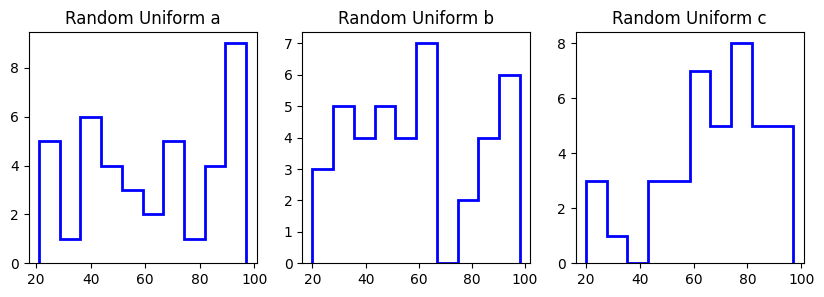

P Value para o Shapiro da Distb: a -> P-Valor: 0.0190
P Value para o Shapiro da Distb: b -> P-Valor: 0.0266
P Value para o Shapiro da Distb: c -> P-Valor: 0.0286


In [138]:
fig, ax = plt.subplots( 1, 3, figsize=(10, 3) )
for i in zip( collect(1:3), ["a", "b", "c"] )
    ax[i[1]].hist( df[i[1]], histtype="step", color="b", linewidth=2);
    ax[i[1]].set_title("Random Uniform " * i[2])
    @printf "P Value para o Shapiro da Distb: %s -> P-Valor: %.4f\n" i[2] ss.shapiro( df[i[1]] )[2]
end

Logo o teste Kruskal para a análise de variância das três ou mais distribuições que não são normais.

In [146]:
f_stats, p_value = ss.kruskal( df[1], df[2], df[3] )
@printf "Estatística F: %.4f\nP-Valor: %.4f" f_stats p_value

Estatística F: 2.9243
P-Valor: 0.2317

In [148]:
# Existe no mesmo pacote outra forma de rodar a função do Kruskal
f_stats, p_value = ss.mstats.kruskalwallis( df[1], df[2], df[3] )
@printf "Estatística F: %.4f\nP-Valor: %.4f" f_stats p_value

Estatística F: 2.9243
P-Valor: 0.2317

### 3.6.2. Anova no Statsmodels

No Statsmodels você desenha a matriz para o ordinary least-square regressor com as formulas.
 - Nesse exemplo é um teste unicaldal com o mesmo p valor do scipy e so funciona com um dataframe do pandas.

In [293]:
py"anova"(df1, 2, "F", "Time ~ Page")

,sum_sq,df,F,PR(>F)
Page,831.4,3.0,2.739825,0.077586
Residual,1618.4,16.0,NaN,NaN


Ok, você fez todos esses testes, mas qual dos grupos realmente é diferente logo que o p-valor foi pequeno?

In [362]:
list = [df[df.Page .== "Page 1", 2], df[df.Page .== "Page 2", 2], df[df.Page .== "Page 3", 2], df[df.Page .== "Page 4", 2]];
pg = ["Page 1", "Page 2", "Page 3", "Page 4"];

In [369]:
for i in zip( pg, list ), k in 1:4
    @printf "\n%s - %s\n" i[1] pg[k]
    println(ss.ttest_ind(i[2], list[k]))
end


Page 1 - Page 1
(0.0, 1.0)

Page 1 - Page 2
(-1.3859292911256307, 0.20317499853824886)

Page 1 - Page 3
(-0.34030136960725227, 0.7423928129048489)

Page 1 - Page 4
(1.156191733258663, 0.28096106091142226)

Page 2 - Page 1
(1.3859292911256307, 0.20317499853824886)

Page 2 - Page 2
(0.0, 1.0)

Page 2 - Page 3
(1.2650143347589609, 0.24146881279653873)

Page 2 - Page 4
(4.950587917224828, 0.001120056434441126)

Page 3 - Page 1
(0.34030136960725227, 0.7423928129048489)

Page 3 - Page 2
(-1.2650143347589609, 0.24146881279653873)

Page 3 - Page 3
(0.0, 1.0)

Page 3 - Page 4
(1.9782125034804172, 0.08327876770509358)

Page 4 - Page 1
(-1.156191733258663, 0.28096106091142226)

Page 4 - Page 2
(-4.950587917224828, 0.001120056434441126)

Page 4 - Page 3
(-1.9782125034804172, 0.08327876770509358)

Page 4 - Page 4
(0.0, 1.0)


Somente em relação a página 4 com a página 2 o p-value ficou pequeno. 

### 3.4.1. Bonferroni & Sidak Correction

Quando se trabalha com a Anova ou multiplos testes t, geralmente podem superestimar a significância, ou seja, maior a chance de encontrar p valores pequenos, uma forma de corrigir esse problema é com a correção de bonferroni, que nada mais é que dividir o nível de significância pelo número unicos de comparações feitas, por exemplo $0.05 \div 6 = 0.0083%$<br>
Com a correção de Sidak, a formula é $1 - (1 - 0.05)^{(1/6)} = 0.0085$.<br>Outro comuntemte utilizado tambem é o Tukey's test 

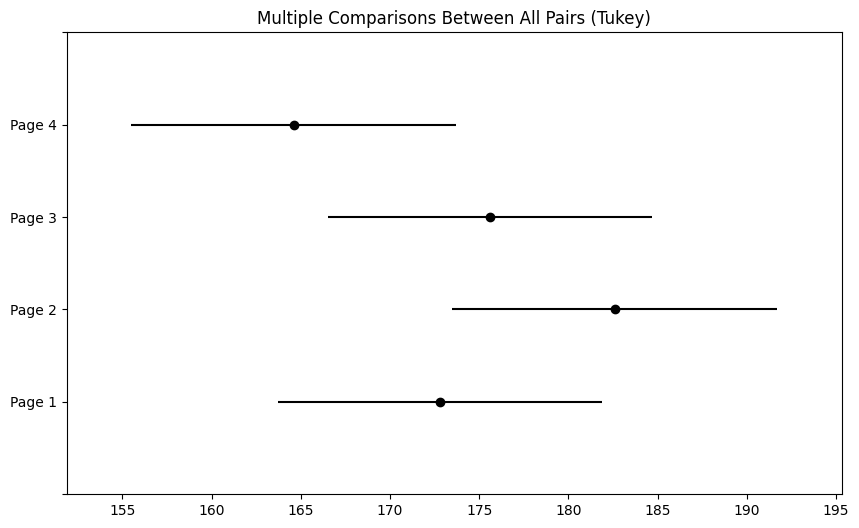

,group1,group2,meandiff,p-adj,lower,upper,reject
1,Page 1,Page 2,9.8,0.4393,-8.3999,27.9999,False
2,Page 1,Page 3,2.8,0.9,-15.3999,20.9999,False
3,Page 1,Page 4,-8.2,0.5758,-26.3999,9.9999,False
4,Page 2,Page 3,-7.0,0.6774,-25.1999,11.1999,False
5,Page 2,Page 4,-18.0,0.0531,-36.1999,0.1999,False
6,Page 3,Page 4,-11.0,0.3419,-29.1999,7.1999,False


In [427]:
py"tukey"(df1.Time, df1.Page, 0.05)

# x.0. Referências

PETER BRUCE & ANDREW BRUCE **Estatística prática para cientistas de dados: 50 conceitos essenciais**.
<br>Link: https://www.amazon.com.br/Estat%C3%ADstica-Pr%C3%A1tica-Para-Cientistas-Dados/dp/855080603X<br><br>
DAVID MATOS **8 Conceitos Estatísticos Fundamentais Para Data Science**. <br>Link: https://www.cienciaedados.com/8-conceitos-estatisticos-fundamentais-para-data-science/<br><br>IGOR SOARES **Correlação não implica em Causalidade**.<br>Link: https://medium.com/@felipemaiapolo/correla%C3%A7%C3%A3o-n%C3%A3o-implica-em-causalidade-8459179ad1bc.<br><br>annahaensch **Número de Casos de Divórcio em Maine**<br>Link: https://blogs.ams.org/blogonmathblogs/2017/04/10/divorce-and-margarine/<br><br>Wikipédia **Cramer's_V**<br>Link: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V<br><br>BURKEYACADEMY **What are Skewness and Kurtosis?**<br>Link: https://www.youtube.com/watch?v=lK7nLzxiAQQ<br><br>
(Discourse) **qqnorm & qqplot**<br>Link: https://discourse.julialang.org/t/qqnorm-and-qqplot/6118/8<br><br>
Professor Guru **Tabela Normal Padrão**<br>Link: https://professorguru.com.br/tabela-normal.html<br><br>
Univesp **Probabilidade e Estatística**<br>Link: https://www.youtube.com/watch?v=7VQE278hIXc&list=PLxI8Can9yAHeeWqe3m9HZFiBhT33Mfxew<br><br>
Todd Grande **Bonferroni**<br>Link: https://www.youtube.com/watch?v=pbWkwEz-XBY<br><br>
Zach **Kruskall Wallis**<br>Link: https://www.statology.org/kruskal-wallis-test-python/#:~:text=A%20Kruskal%2DWallis%20Test%20is,of%20the%20One%2DWay%20ANOVA.<br><br>
USP **Teste Exato de Fisher**<br>Link: http://wiki.icmc.usp.br/images/7/73/Chisq-fisher.pdf<br><br>